In [1]:
from functions import *
from scipy.integrate import solve_ivp

In [2]:
n = 5

# Temperature sweep

In [3]:
def get_proposal_mat_ra(m, ramp_up_schedule, t_max):
    H_ising = np.diag(m.E_rescaled)
    H_mixer = H_mixer_list[m.n-1]
    d = int(2**m.n)

    def s(t): return t/t_max

    def f(s, ramp_up_schedule):
        # Check if s is outside the range of the points
        if s < 0 or s > 1: raise ValueError("t is out of the bounds")
        
        schedule = np.concatenate([ramp_up_schedule, ramp_up_schedule[::-1][1:]])
        n_points = len(schedule)
        times = np.linspace(0, 1, n_points)
        time_step = 1 / (n_points - 1)

        # Find the correct interval for x
        for i in range(n_points - 1):
            if times[i] <= s <= times[i+1]:
                # Extract points (x0, y0) and (x1, y1)
                y0 = schedule[i]
                s0 = times[i]
                y1 = schedule[i + 1]
                # Linear interpolation formula
                return y0 + (y1 - y0) * (s - s0) / time_step

    def hamiltonian(t): return (1-f(s(t), ramp_up_schedule))*H_ising + f(s(t), ramp_up_schedule)*H_mixer

    def tdse_U(t, U): 
        return -1j*(hamiltonian(t)@U.reshape(d,d)).flatten()
    
    U0 = np.eye(d, dtype=complex).flatten()
    sol = solve_ivp(tdse_U, 
                    [0, t_max], 
                    y0=U0, 
                    rtol=1e-10, 
                    method='RK23')
    
    U_t = sol.y.T[-1].reshape(d,d)
    return np.abs(U_t)**2

In [4]:
num_random_models = 10
num_temperatures = 10

T_range = np.geomspace(0.001, 1000, num_temperatures)

ramp_up_schedule = np.array([-0.0657428 ,  0.14598069,  0.27127482,  0.85253383,  1.33444081]) # n = 5 COBYLA
t_max = 10

def f(T):
    '''
    Calculate spectral gaps for quantum and mismatched proposals.
    f(T) is defined to parallelize the temperature-loop.
    '''   
    delta_random_arr = np.zeros((num_random_models))
    delta_local_arr = np.zeros((num_random_models))
    delta_quantum_arr = np.zeros((num_random_models))
    delta_mismatched_quantum_arr = np.zeros((num_random_models))
    delta_ra_arr = np.zeros((num_random_models))

    for i in range(num_random_models):
        m = RandomIsingModel(n, seed=i) # set the seed for reproducibility

        proposal_mat_random = get_proposal_mat_random(m)
        P_random = get_transition_matrix(m, T, proposal_mat_random)
        delta_random = get_delta(P_random)
        delta_random_arr[i] = delta_random

        proposal_mat_local = get_proposal_mat_local(m)
        P_local = get_transition_matrix(m, T, proposal_mat_local)
        delta_local = get_delta(P_local)
        delta_local_arr[i] = delta_local
    
        proposal_mat_quantum = get_proposal_mat_quantum_avg(m)
        P_quantum = get_transition_matrix(m, T, proposal_mat_quantum)
        delta_quantum = get_delta(P_quantum)
        delta_quantum_arr[i] = delta_quantum

        # m_mismatched = RandomIsingModel(n, seed=i+num_random_models) # set the seed for reproducibility
        # proposal_mat_mismatched_quantum = get_proposal_mat_quantum_layden(m_mismatched)
        # P_mismatched_quantum = get_transition_matrix(m, T, proposal_mat_mismatched_quantum)
        # delta_mismatched_quantum = get_delta(P_mismatched_quantum)
        # delta_mismatched_quantum_arr[i] = delta_mismatched_quantum

        proposal_mat_ra = get_proposal_mat_ra(m, ramp_up_schedule, t_max)
        P_ra = get_transition_matrix(m, T, proposal_mat_ra)
        delta_ra = get_delta(P_ra)
        delta_ra_arr[i] = delta_ra

    return delta_random_arr, delta_local_arr, delta_quantum_arr, delta_mismatched_quantum_arr, delta_ra_arr

In [5]:
sweep_data = np.asarray(joblib.Parallel(n_jobs=-1)(joblib.delayed(f)(T) for T in tqdm(T_range)))
sweep_data = sweep_data.swapaxes(0,1)

100%|██████████| 10/10 [00:00<00:00, 21.00it/s]


In [6]:
delta_random_arr = sweep_data[0]
delta_local_arr = sweep_data[1]
delta_quantum_arr = sweep_data[2]
delta_mismatched_quantum_arr = sweep_data[3]
delta_ra_arr = sweep_data[4]

# Save the data

In [7]:
# # Save the results for long sweeps
# temperature_sweep = {'local': delta_local_arr,
#                      'uniform': delta_random_arr,
#                      'quantum': delta_quantum_arr,
#                      'mismatched': delta_mismatched_quantum_arr,
#                      'ra': delta_ra_arr}

In [8]:
# pickle.dump(temperature_sweep, open(f'data/temperature_sweep_n{n}.p','wb'))

In [9]:
# temperature_sweep = pickle.load(open(f'data/temperature_sweep_n{n}.p','rb'))
# delta_local_arr = temperature_sweep['local']
# delta_random_arr = temperature_sweep['uniform']
# delta_quantum_arr = temperature_sweep['quantum']
# delta_mismatched_quantum_arr = temperature_sweep['mismatched']

# Average and plot the results

In [10]:
# Take an average over random Ising instances
delta_random_arr_avg = np.mean(delta_random_arr, axis=1)
delta_random_arr_std = np.std(delta_random_arr, axis=1)

delta_local_arr_avg = np.mean(delta_local_arr, axis=1)
delta_local_arr_std = np.std(delta_local_arr, axis=1)

delta_quantum_arr_avg = np.mean(delta_quantum_arr, axis=1)
delta_quantum_arr_std = np.std(delta_quantum_arr, axis=1)

# delta_mismatched_quantum_arr_avg = np.mean(delta_mismatched_quantum_arr, axis=1)
# delta_mismatched_quantum_arr_std = np.std(delta_mismatched_quantum_arr, axis=1)

delta_ra_arr_avg = np.mean(delta_ra_arr, axis=1)
delta_ra_arr_std = np.std(delta_ra_arr, axis=1)

In [13]:
# def loss(ramp_up_schedule, t_max = 10):
#     delta_avg = 0
#     n_random_models = 10
#     for seed in range(n_random_models):
#         m = RandomIsingModel(n=n, seed=seed)
#         proposal_mat_ra = get_proposal_mat_ra(m, ramp_up_schedule, t_max)
#         P = get_transition_matrix(m, 0.1, proposal_mat_ra)
#         delta_avg += get_delta(P) / n_random_models
#     return -delta_avg

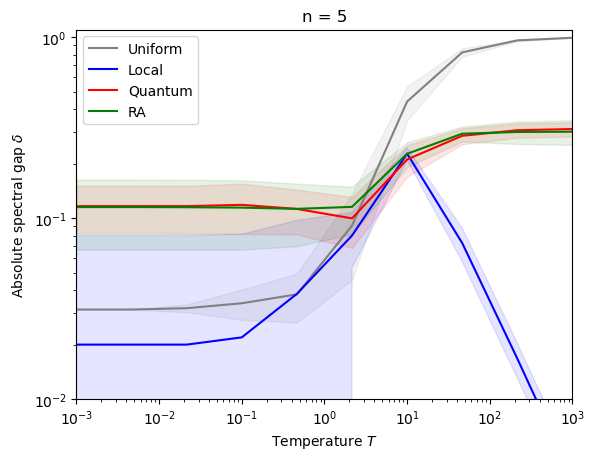

In [14]:
plt.plot(T_range, delta_random_arr_avg, '-', color='grey', label = 'Uniform')
plt.plot(T_range, delta_local_arr_avg, '-', color='blue', label = 'Local')
plt.plot(T_range, delta_quantum_arr_avg, '-', color='red', label = 'Quantum')
# plt.plot(T_range, delta_mismatched_quantum_arr_avg, '-', color='orange', label = 'Mismatched quantum')
plt.plot(T_range, delta_ra_arr_avg, '-', color='green', label = 'RA')

plt.fill_between(T_range, 
                 delta_random_arr_avg-delta_random_arr_std, 
                 delta_random_arr_avg+delta_random_arr_std, 
                 color='grey',
                 alpha=0.1)
plt.fill_between(T_range, 
                 delta_local_arr_avg-delta_local_arr_std, 
                 delta_local_arr_avg+delta_local_arr_std, 
                 color='blue',
                 alpha=0.1)
plt.fill_between(T_range, 
                 delta_quantum_arr_avg-delta_quantum_arr_std, 
                 delta_quantum_arr_avg+delta_quantum_arr_std, 
                 color='red',
                 alpha=0.1)
# plt.fill_between(T_range, 
#                  delta_mismatched_quantum_arr_avg-delta_mismatched_quantum_arr_std, 
#                  delta_mismatched_quantum_arr_avg+delta_mismatched_quantum_arr_std, 
#                  color='orange',
#                  alpha=0.1)
plt.fill_between(T_range, 
                 delta_ra_arr_avg-delta_ra_arr_std, 
                 delta_ra_arr_avg+delta_ra_arr_std, 
                 color='green',
                 alpha=0.1)

plt.title(f'n = {n}')
plt.xlabel('Temperature $T$')
plt.ylabel('Absolute spectral gap $\delta$')
plt.ylim(0.01, 1.1)
plt.xlim(0.001, 1000)
plt.yscale('log')
plt.xscale('log')
plt.legend()